In [1]:
import pytimber as pt
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc

import pandas as pd
import numpy as np
import scipy.optimize as opt
import scipy.optimize as opt
from scipy.special import erf
from scipy.stats import norm

from matplotlib.ticker import FixedLocator


is_swan = False
if is_swan == False:
    from nxcals.spark_session_builder import get_or_create
    from nxcals.api.extraction.data.builders import DataQuery
    spark = get_or_create("My_APP")

ENVIRONMENT:
NXCALS_VERSION=1.5.8
VIRTUAL_ENV=
SPARK_HOME=/home/cmaccani/anaconda3/nxcals-bundle
SPARK_CONF_DIR=/tmp/cmaccani/nxcals-a3e0836dfec1b3b0ad0b1bd785a21fb6/conf
SPARK_DEFAULTS=/home/cmaccani/anaconda3/nxcals-bundle/conf/spark-defaults.conf
NXCALS_WORKSPACE_TEMP_DIR=/tmp/cmaccani/nxcals-a3e0836dfec1b3b0ad0b1bd785a21fb6
PACKED_VENV_FILE=/tmp/cmaccani/nxcals-a3e0836dfec1b3b0ad0b1bd785a21fb6/nxcals-python3-env.tar.gz
PYSPARK_PYTHON=/home/cmaccani/anaconda3/bin/python
PYSPARK_DRIVER_PYTHON=/bin/python
PYSPARK_DRIVER_PYTHON_OPTS=
LOCK=/tmp/cmaccani/nxcals-a3e0836dfec1b3b0ad0b1bd785a21fb6/.lock

IMPORTANT:
Rebuilding of the packed venv is required in cases there are new or modified packages provided by a user. In order to recreate the packed venv please:
        - remove the file (rm /tmp/cmaccani/nxcals-a3e0836dfec1b3b0ad0b1bd785a21fb6/nxcals-python3-env.tar.gz)
        - execute your script again (rebuild will be performed during the startup of PySpark/Python)
Target directory can

In [2]:
def datestring_to_timestamp_utc(date_string):
    # Parse the date string into a datetime object
    date_obj = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S') - timedelta(hours=2)
    
    # Convert the datetime object to UTC timezone if it's not already in UTC
    if date_obj.tzinfo is None or date_obj.tzinfo.utcoffset(date_obj) is None:
        date_obj = date_obj.replace(tzinfo=timezone.utc)
    else:
        date_obj = date_obj.astimezone(timezone.utc)
    
    # Extract the timestamp in seconds
    timestamp_utc = date_obj.timestamp()
    
    return timestamp_utc


def utc_timestamp_to_date_string(timestamp):
    # Convert the timestamp to a datetime object in UTC
    utc_datetime = datetime.fromtimestamp(timestamp, tz=timezone.utc)
    
    # Format the datetime object to a string
    date_string = utc_datetime.strftime('%Y-%m-%d %H:%M:%S')
    
    return date_string

In [3]:
# B2H 2023 Specifications
length = 4e-3
bending_angle = 47.1e-6

R = length / bending_angle
pot_crit = 21.34 #16 #eV Silicon
en_crit = 5.7e9 / 1e-2


def get_xpcrit(p0c):
    xp_crit0 = np.sqrt(2.0*pot_crit/p0c)
    Rcrit = p0c/en_crit
    xp_crit = xp_crit0*(1-Rcrit/R)
    return xp_crit

print(get_xpcrit(450e9), get_xpcrit(1000e9), get_xpcrit(3000e9), get_xpcrit(5000e9))

9.648278742014374e-06 6.398035302821452e-06 3.5380714612044096e-06 2.619868366864124e-06


In [4]:
lbd = pt.LoggingDB(source='nxcals', spark_session=spark)

In [5]:
abs_metadata = 'BLMTI.04R7.B2I10_TCSPM.B4R7.B2:LOSS_RS09'
cry_metadata = 'BLMTI.05R7.B2I10_TCPCH.A5R7.B2:LOSS_RS09'
blm_metadata = 'BLMTI.04R7.B2I10_TCSG.B4R7.B2:LOSS_RS09'
lin_metadata = 'TCSG.B4R7.B2:MEAS_MOTOR_LU'
int_metadata = 'LHC.BCTFR.A6R4.B2:BEAM_INTENSITY'
ang_metadata = 'TCPCH.A5R7.B2_ROT:YAWANGLE'
prim_metadata = 'TCP.C6R7.B2:MEAS_MOTOR_LU'

#lin_metadata = 'TCSPM.B4R7.B2:MEAS_MOTOR_LU'


# Angular Scan

In [6]:
energy = 1000
scan = 2

In [7]:
# INJECTION ANGULAR SCAN
if energy == 450:
    if scan == 1:
        tMin = '2024-05-15 13:21:27'
        tMax = '2024-05-15 13:24:39'
        am_ur = 55
        ch_l = 70
        ch_r = 96
        vr = 130
        am_dl = 150

    elif scan == 2:
        tMin = '2024-05-15 13:25:40'
        tMax = '2024-05-15 13:27:57'
    elif scan == 3:
        tMin = '2024-05-15 13:30:19'
        tMax = '2024-05-15 13:34:05'
        
# 1 TeV ANGULAR SCAN
elif energy == 1000:
    if scan == 1:
        tMin = '2024-05-15 15:10:38'
        tMax = '2024-05-15 15:14:01'
    elif scan == 2:
        tMin = '2024-05-15 15:15:38'
        tMax = '2024-05-15 15:18:41'
        am_ur = 48
        ch_l = 58
        ch_r = 79
        vr = 120
        am_dl = 130

# 3 TeV ANGULAR SCAN
elif energy == 3000:
    if scan == 1:
        tMin = '2024-05-15 16:23:30'
        tMax = '2024-05-15 16:28:51'
    elif scan == 2:
        tMin = '2024-05-15 16:31:09'
        tMax = '2024-05-15 16:35:17'
        
# 5 TeV ANGULAR SCAN
elif energy == 5000:
    if scan == 1:
        tMin = '2024-05-15 17:38:46'
        tMax = '2024-05-15 17:42:18'
    elif scan == 2:
        tMin = '2024-05-15 17:43:43'
        tMax = '2024-05-15 17:46:44'

/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()


Text(0, 0.5, 'BLM signal [a.u.]')

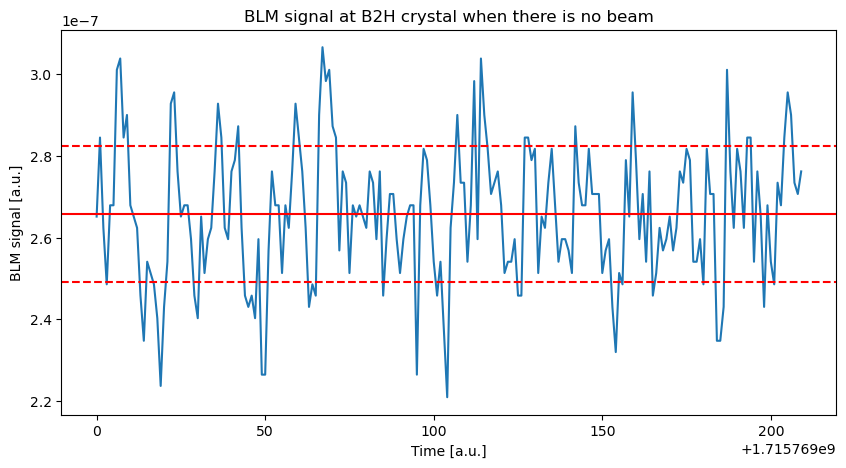

In [8]:
# take some data from the BLMs when there is no beam, so to find the background
cry_blm_background = lbd.get(cry_metadata, '2024-05-15 12:30:00', '2024-05-15 12:33:30')
MeanBLMCryBkg_NoBeam = np.mean( cry_blm_background[cry_metadata][1])
StdBLMCryBkg_NoBeam = np.std( cry_blm_background[cry_metadata][1])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(cry_blm_background[cry_metadata][0], cry_blm_background[cry_metadata][1])
ax.axhline(MeanBLMCryBkg_NoBeam, color='r')
ax.axhline(MeanBLMCryBkg_NoBeam + StdBLMCryBkg_NoBeam, color='r', linestyle='--')
ax.axhline(MeanBLMCryBkg_NoBeam - StdBLMCryBkg_NoBeam, color='r', linestyle='--')
ax.set_title('BLM signal at B2H crystal when there is no beam')
ax.set_xlabel('Time [a.u.]')
ax.set_ylabel('BLM signal [a.u.]')

In [9]:
data = lbd.get([cry_metadata, ang_metadata, int_metadata, abs_metadata],  tMin , tMax )

/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()
/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()
/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  )

In [10]:
mot =  data[ang_metadata][1]
time = data[ang_metadata][0]
signal =  data[cry_metadata][1]
beam_intensity = data[int_metadata][1]
absorber_signal = data[abs_metadata][1]

#### Plot 

In [376]:
# Identify channeling
# 0. set initial time to zero so it's easier
t0 = time[0]
time_scan = [i - t0 for i in time]

Text(0, 0.5, 'Beam flux [p/s]')

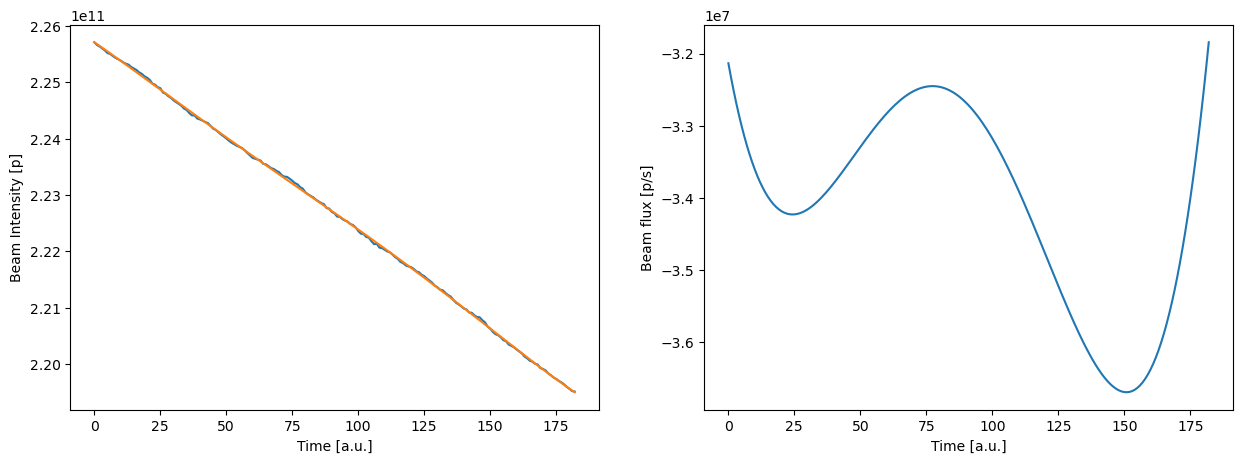

In [377]:
#1. Fit the intensity curve to find the beam flux
fig, ax = plt.subplots(1,2, figsize=(15,5))

order = 5
p = np.polyfit(time_scan, beam_intensity, order)

ax[0].plot(time_scan, beam_intensity)
ax[0].plot(time_scan, np.polyval(p, time_scan))
ax[0].set_xlabel('Time [a.u.]')
ax[0].set_ylabel('Beam Intensity [p]')
q = np.polyder(p)
ax[1].plot(time_scan, np.polyval(q, time_scan))
ax[1].set_xlabel('Time [a.u.]')
ax[1].set_ylabel('Beam flux [p/s]')

Text(0, 0.5, 'BLM signal')

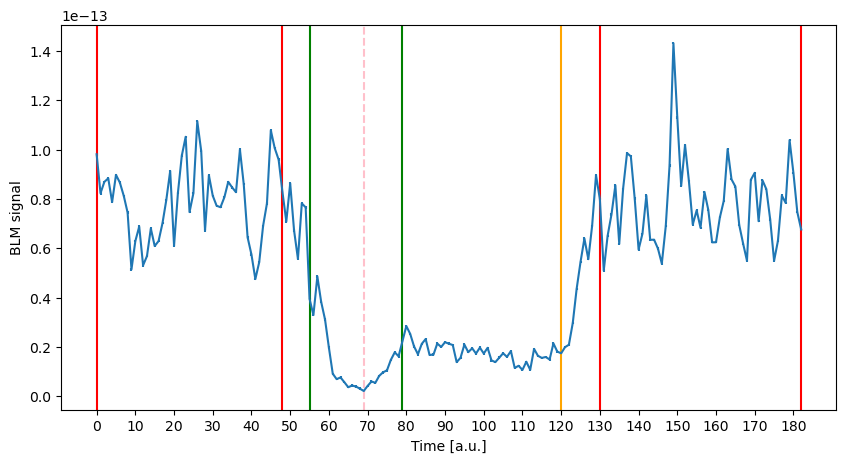

In [378]:
# 2. Subtract the mean of the background when there is no beam 
# Normalize by beam flux
cry_blm = [(signal[i]-MeanBLMCryBkg_NoBeam)/abs(np.polyval(q, time_scan[i])) for i in range(len(signal))]
cry_blm_err = [StdBLMCryBkg_NoBeam/abs(np.polyval(q, time_scan[i])) for i in range(len(signal))]

# 3. Plot bands
fig, ax = plt.subplots( figsize=(10,5))
#ax.plot(time_scan, cry_blm)
ax.errorbar(time_scan, cry_blm, yerr = cry_blm_err)
#plt.plot(mot, cry_blm)

set_bands = True
if set_bands == True:
    am_ur = 48
    ch_l = 55
    ch_r = 79
    vr = 120
    am_dl = 130

ax.axvline(0, color = 'r')
ax.axvline(am_ur, color = 'r')
ax.axvline(ch_l, color = 'g')
ax.axvline(ch_r, color = 'g')
ax.axvline(vr, color = 'orange')
ax.axvline(am_dl, color = 'r')
ax.axvline(time_scan[-1], color = 'r')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, time_scan[-1], 10))
ax.axvline(time_scan[np.where(cry_blm == min(cry_blm))[0][0]], color = 'pink', linestyle = '--')
ax.set_xlabel('Time [a.u.]')
ax.set_ylabel('BLM signal')

In [379]:
amorph_UL = mot[np.where(time_scan==min(time_scan, key=lambda x: abs(x - 0)))] 
amorph_UR = mot[np.where(time_scan==min(time_scan, key=lambda x: abs(x - am_ur)))] 
chann_L = mot[np.where(time_scan==min(time_scan, key=lambda x: abs(x - ch_l)))] 
chann_R = mot[np.where(time_scan==min(time_scan, key=lambda x: abs(x - ch_r)))] 
VR_R = mot[np.where(time_scan==min(time_scan, key=lambda x: abs(x - vr)))] 
amorph_DL = mot[np.where(time_scan==min(time_scan, key=lambda x: abs(x - am_dl)))] 
amorph_DR = mot[np.where(time_scan==time_scan[-1])]

print('Length of volume reflection region: ',np.abs(mot[np.where(cry_blm == min(cry_blm))[0][0]] - VR_R)[0], ' urad')

Length of volume reflection region:  56.10100215911871  urad


Text(0, 0.5, 'BLM signal')

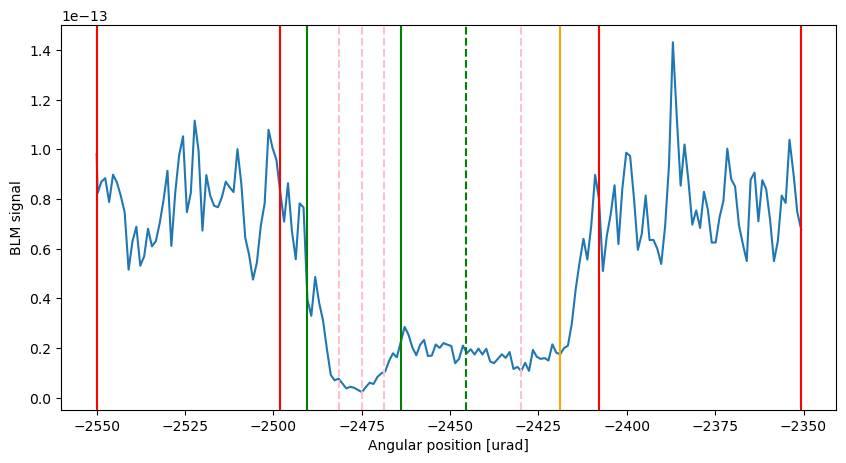

In [380]:
bend = 45

fig, ax = plt.subplots( figsize=(10,5))
ax.plot(mot, cry_blm)
#ax.plot(mot, cry_blm)
ax.axvline(amorph_UL, color = 'r')
ax.axvline(amorph_UR, color = 'r')
ax.axvline(chann_L, color = 'g')
ax.axvline(chann_R, color = 'g')
ax.axvline(VR_R, color = 'orange')
ax.axvline(amorph_DL, color = 'r')
ax.axvline(amorph_DR, color = 'r')
ax.axvline(mot[np.where(cry_blm == min(cry_blm))]+bend, color = 'pink', linestyle = '--')
ax.axvline(chann_L+bend, color = 'g', linestyle = '--')
ax.axvline(mot[np.where(cry_blm == min(cry_blm))], color = 'pink', linestyle = '--')
ax.axvline(mot[np.where(cry_blm == min(cry_blm))]+get_xpcrit(energy*1e9)*1e6, color = 'pink', linestyle = '--')
ax.axvline(mot[np.where(cry_blm == min(cry_blm))]-get_xpcrit(energy*1e9)*1e6, color = 'pink', linestyle = '--')

ax.set_xlabel('Angular position [urad]')
ax.set_ylabel('BLM signal')

In [381]:
# 4. Normalize by amorphous region
amorph_mean = np.mean(np.concatenate([cry_blm[np.where(mot == amorph_DL)[0][0]:np.where(mot == amorph_DR)[0][0]], 
                        cry_blm[np.where(mot == amorph_UL)[0][0]:np.where(mot == amorph_UR)[0][0]] ]))
amorph_std = np.std(np.concatenate([cry_blm[np.where(mot == amorph_DL)[0][0]:np.where(mot == amorph_DR)[0][0]], 
                        cry_blm[np.where(mot == amorph_UL)[0][0]:np.where(mot == amorph_UR)[0][0]] ]))
cry_sgn_blm = np.array([i/amorph_mean for i in cry_blm])
cry_sgn_blm_err = np.array([ np.sqrt((cry_blm_err[i]/ amorph_mean)**2  + (( cry_blm[i] / amorph_mean**2 )*amorph_std )**2) for i in range(len(cry_blm))])
#cry_sgn_blm_err = np.array([ ( i / amorph_mean**2 )*amorph_std  for i in cry_blm])


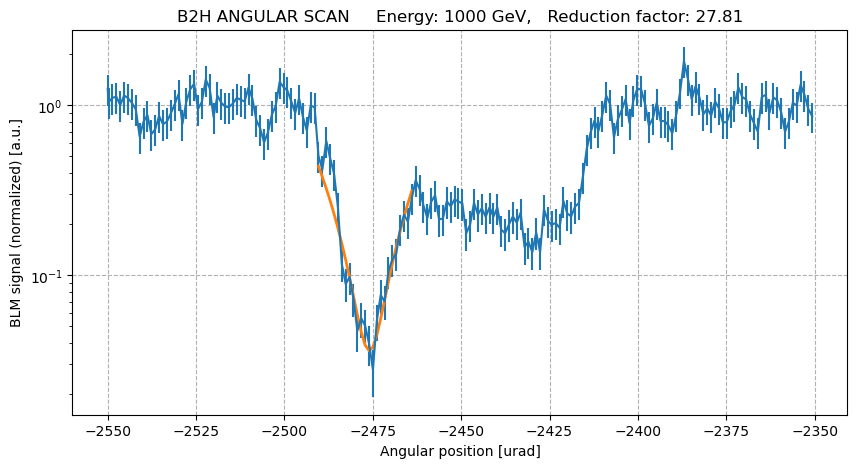

In [382]:
# 5. Fit the channeling region
#fit_type = 'xpcrit'
fit_type = 'manual_bands'

if fit_type == 'xpcrit':
    #in 10urad (+- critical angle) range around minimum
    chann_ang_range = mot[np.where((mot >= mot[np.where(cry_blm == min(cry_blm))]-get_xpcrit(energy*1e9)*1e6) & (mot <= mot[np.where(cry_blm == min(cry_blm))]+get_xpcrit(energy*1e9)*1e6))]
    chann_signal = cry_sgn_blm[np.where((mot >= mot[np.where(cry_blm == min(cry_blm))]-get_xpcrit(energy*1e9)*1e6) & (mot <= mot[np.where(cry_blm == min(cry_blm))]+get_xpcrit(energy*1e9)*1e6))]
    chann_sign_err = cry_sgn_blm_err[np.where((mot >= mot[np.where(cry_blm == min(cry_blm))]-get_xpcrit(energy*1e9)*1e6) & (mot <= mot[np.where(cry_blm == min(cry_blm))]+get_xpcrit(energy*1e9)*1e6))]
elif fit_type == 'manual_bands':
    #in chosen range
    chann_ang_range = mot[np.where((mot >= chann_L) & (mot <= chann_R))]
    chann_signal = cry_sgn_blm[np.where((mot >= chann_L) & (mot <= chann_R))]
    chann_sign_err = cry_sgn_blm_err[np.where((mot >= chann_L) & (mot <= chann_R))]

#coeff_chann_well = np.polyfit(chann_ang_range, chann_signal, 2)    
coeff_chann_well, cov_fit_chann = np.polyfit(chann_ang_range, chann_signal, 2, w=1/chann_sign_err, cov=True)
# Find minimum of the well (alignment angle)
chann_align_angle = np.roots(np.polyder(coeff_chann_well))


fig, ax = plt.subplots(figsize=(10, 5))
#ax.plot(mot, cry_sgn_blm)
ax.errorbar(mot, cry_sgn_blm, yerr=cry_sgn_blm_err)
ax.plot(chann_ang_range, np.polyval(coeff_chann_well, chann_ang_range), linewidth=2)

plot_limits = False
if plot_limits:
    if fit_type == 'xpcrit':
        ax.axvline(chann_align_angle + get_xpcrit(energy*1e9)*1e6, color = 'r', linestyle = '--')
        ax.axvline(chann_align_angle - get_xpcrit(energy*1e9)*1e6, color = 'r', linestyle = '--')
    elif fit_type == 'manual_bands':
        ax.axvline(chann_L, color = 'r', linestyle = '--')
        ax.axvline(chann_R, color = 'r', linestyle = '--')
    ax.axvline(chann_align_angle, color = 'orange')
    ax.axvline(chann_R+bend, color = 'g', linestyle = '--')
    ax.axvline(chann_align_angle+bend, color = 'pink', linestyle = '--')
    ax.axhline(np.polyval(coeff_chann_well, chann_align_angle), color = 'orange', linestyle = '--')
    ax.axhline(1, color = 'orange', linestyle = '--')



ax.set_title(f'B2H ANGULAR SCAN     Energy: {energy} GeV,   Reduction factor: {1/np.polyval(coeff_chann_well, chann_align_angle)[0]:.2f}')
ax.set_yscale('log')
ax.grid(linestyle='--')
ax.set_xlabel('Angular position [urad]')
ax.set_ylabel('BLM signal (normalized) [a.u.]')

plot_absorber = False
if plot_absorber:
    ax_abs = ax.twinx()
    ax_abs.plot(mot, absorber_signal, 'g')
    ax_abs.set_ylim (-0.5e-4, 1.2e-4)

save_fig = True
if save_fig:
    fig.savefig(f'./Plots/B2H_ANGULAR_SCAN_energy{energy}_scan{scan}.png')

In [383]:
print('Reduction factor:', 1/np.polyval(coeff_chann_well, chann_align_angle))

Reduction factor: [27.80681059]


# Linear Scan

In [11]:
energy = 1000
scan = 1

In [12]:
# LINEAR SCAN

# 1 TeV LINEAR SCAN
if energy == 1000:
    TCP_LU =  4.715e-3
    TCP_RU = -3.595e-3
    if scan == 1:
        tMin_bkg = '2024-05-15 15:25:07'
        tMax_bkg = '2024-05-15 15:26:27'
        tMin = '2024-05-15 15:26:32'
        tMax = '2024-05-15 15:31:12'
        
        PosEnvelope = 3.77
        RangetoMeanEnv= 0.5
        PosMaxErfFit = 5.5
        param0 = [0.5, -1, 6.5, 0.3]

# 3 TeV LINEAR SCAN
elif energy == 3000:
    TCP_LU =  2.86e-3
    TCP_RU = -1.88e-3 
    if scan == 1:
        tMin_bkg = '2024-05-15 16:41:25'
        tMax_bkg = '2024-05-15 16:42:25'  
        tMin = '2024-05-15 16:42:30'
        tMax = '2024-05-15 16:46:55'
    elif scan == 2:
        tMin_bkg = '2024-05-15 16:50:32'
        tMax_bkg = '2024-05-15 16:51:07'
        tMin = '2024-05-15 16:51:12'
        tMax = '2024-05-15 16:55:32'

# 5 TeV LINEAR SCAN
elif energy == 5000:
    TCP_LU = 2.29e-3
    TCP_RU = -1.395e-3
    if scan == 1:
        tMin_bkg = '2024-05-15 17:55:00'
        tMax_bkg = '2024-05-15 17:55:30'
        tMin = '2024-05-15 17:55:35'
        tMax = '2024-05-15 18:00:30'
    elif scan == 2:
        tMin_bkg = '2024-05-15 18:01:53'
        tMax_bkg = '2024-05-15 18:02:04'
        tMin = '2024-05-15 18:02:08'
        tMax = '2024-05-15 18:06:28'



mp = 0.9382
emittance_n = 3.5e-6
gamma = energy/mp
beta = np.sqrt(1-1/(gamma*gamma))
emittance = emittance_n/(beta*gamma)


beta_CRY =  202.14283989353822
alpha_CRY = -3.542768392822383

beta_COLL =   151.98832189100114
alpha_COLL =  1.5212968243622182

deltaphi_CRY_COLL = 0.3320954889610304

CO_TCP = -5.424275667608168e-07
beta_TCP = 140.75752795686023

sigma_TCP = np.sqrt(emittance*beta_TCP)
hgap = (TCP_LU-TCP_RU)/2
n_sigma = hgap/sigma_TCP

In [13]:
n_sigma

6.111578305390542

In [14]:
data = lbd.get(blm_metadata, tMin_bkg , tMax )

/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()


#### Choose time range

tMax_bkg:  2024-05-15 15:26:37
tMin:  2024-05-15 15:26:47


Text(0.5, 1.0, 'Final Overview')

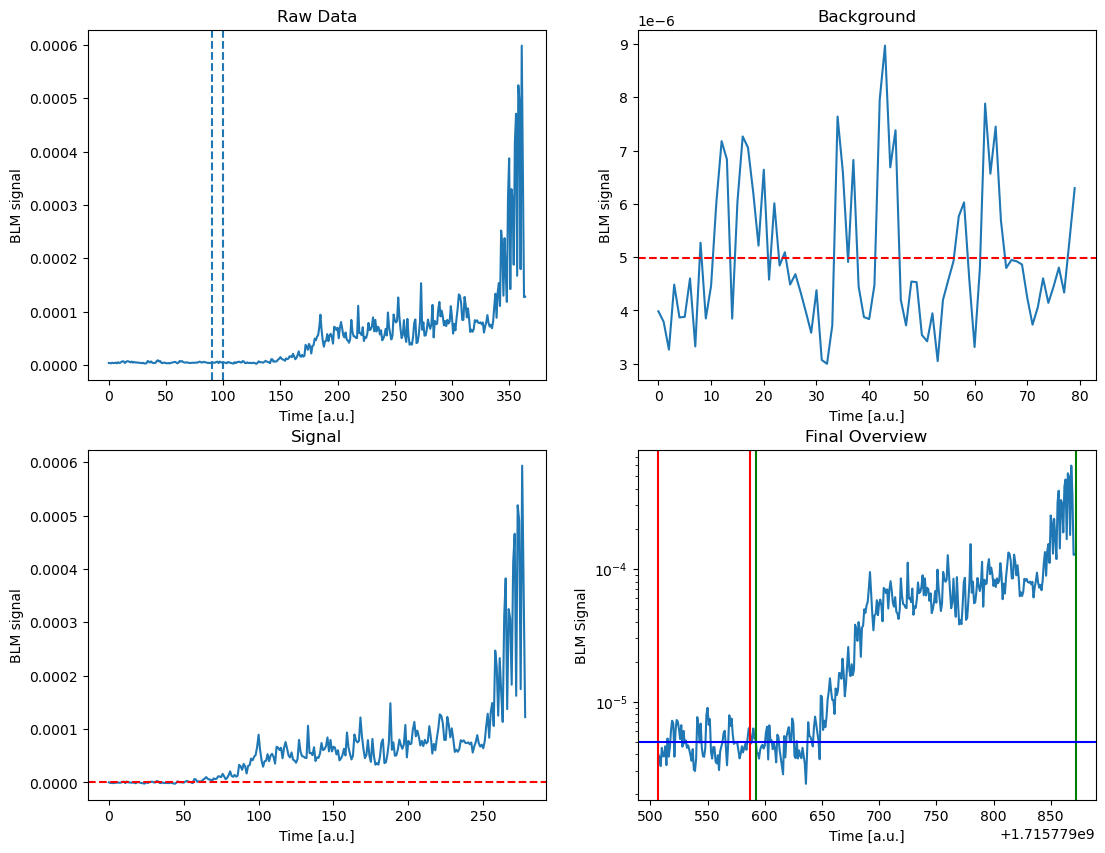

In [15]:
# CHOOSE TIME RANGE
time = data[blm_metadata][0]
signal =  data[blm_metadata][1]

fig, ax = plt.subplots(2, 2,  figsize=(13,10))



# GET TIME REGIONS
t0 = time[0]
time = [i - t0 for i in time]
tMax_bkg_au = 90
tMin_au = 100
ax[0, 0].plot(time, signal)
ax[0,0].axvline(tMax_bkg_au, linestyle='--')
ax[0,0].axvline(tMin_au, linestyle='--')
ax[0,0].set_xlabel('Time [a.u.]')
ax[0,0].set_ylabel('BLM signal')
ax[0,0].set_title('Raw Data')

print('tMax_bkg: ', utc_timestamp_to_date_string(t0 +60*60*2 + tMax_bkg_au))
print('tMin: ', utc_timestamp_to_date_string(t0 +60*60*2 + tMin_au))


# BACKGROUND
time = [i + t0 for i in time]
BLM_bkg = signal[np.where((np.round(time) ==  datestring_to_timestamp_utc(tMin_bkg)))[0][0]:np.where((np.round(time) ==  datestring_to_timestamp_utc(tMax_bkg)))[0][0]]
time_bkg = time[np.where((np.round(time) ==  datestring_to_timestamp_utc(tMin_bkg)))[0][0]:np.where((np.round(time) ==  datestring_to_timestamp_utc(tMax_bkg)))[0][0]]
Delta_time_bkg = np.array([i - time_bkg[0] for i in time_bkg])
bkg_mean = np.mean(BLM_bkg)

ax[0,1].plot(Delta_time_bkg, BLM_bkg)
ax[0,1].axhline(y=bkg_mean, color='r', linestyle='--')
ax[0,1].set_xlabel('Time [a.u.]')
ax[0,1].set_ylabel('BLM signal')
ax[0,1].set_title('Background')

# SIGNAL
BLM_scan = signal[np.where((np.round(time) ==  datestring_to_timestamp_utc(tMin)))[0][0]:np.where((np.round(time) ==  datestring_to_timestamp_utc(tMax)-1))[0][0]]
time_scan = time[np.where((np.round(time) ==  datestring_to_timestamp_utc(tMin)))[0][0]:np.where((np.round(time) ==  datestring_to_timestamp_utc(tMax)-1))[0][0]]
Delta_time_scan = np.array([i - time_scan[0] for i in time_scan])
#substract background
BLM_scan = BLM_scan - bkg_mean

ax[1,0].plot(Delta_time_scan, BLM_scan)
ax[1,0].axhline(y=0, color='r', linestyle='--')
ax[1,0].set_xlabel('Time [a.u.]')
ax[1,0].set_ylabel('BLM signal')
ax[1,0].set_title('Signal')


# COMPLETE OVERVIEW
plt.plot(time, signal)
ax[1,1].axvline(datestring_to_timestamp_utc(tMax_bkg), color = 'r')
ax[1,1].axvline(datestring_to_timestamp_utc(tMin_bkg), color = 'r')
ax[1,1].axvline(datestring_to_timestamp_utc(tMin), color = 'g')
ax[1,1].axvline(datestring_to_timestamp_utc(tMax), color = 'g')
ax[1,1].axhline(bkg_mean, color = 'b')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('Time [a.u.]')
ax[1,1].set_ylabel('BLM Signal')
ax[1,1].set_title('Final Overview')

#### Analysis

/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()
/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()
/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  )

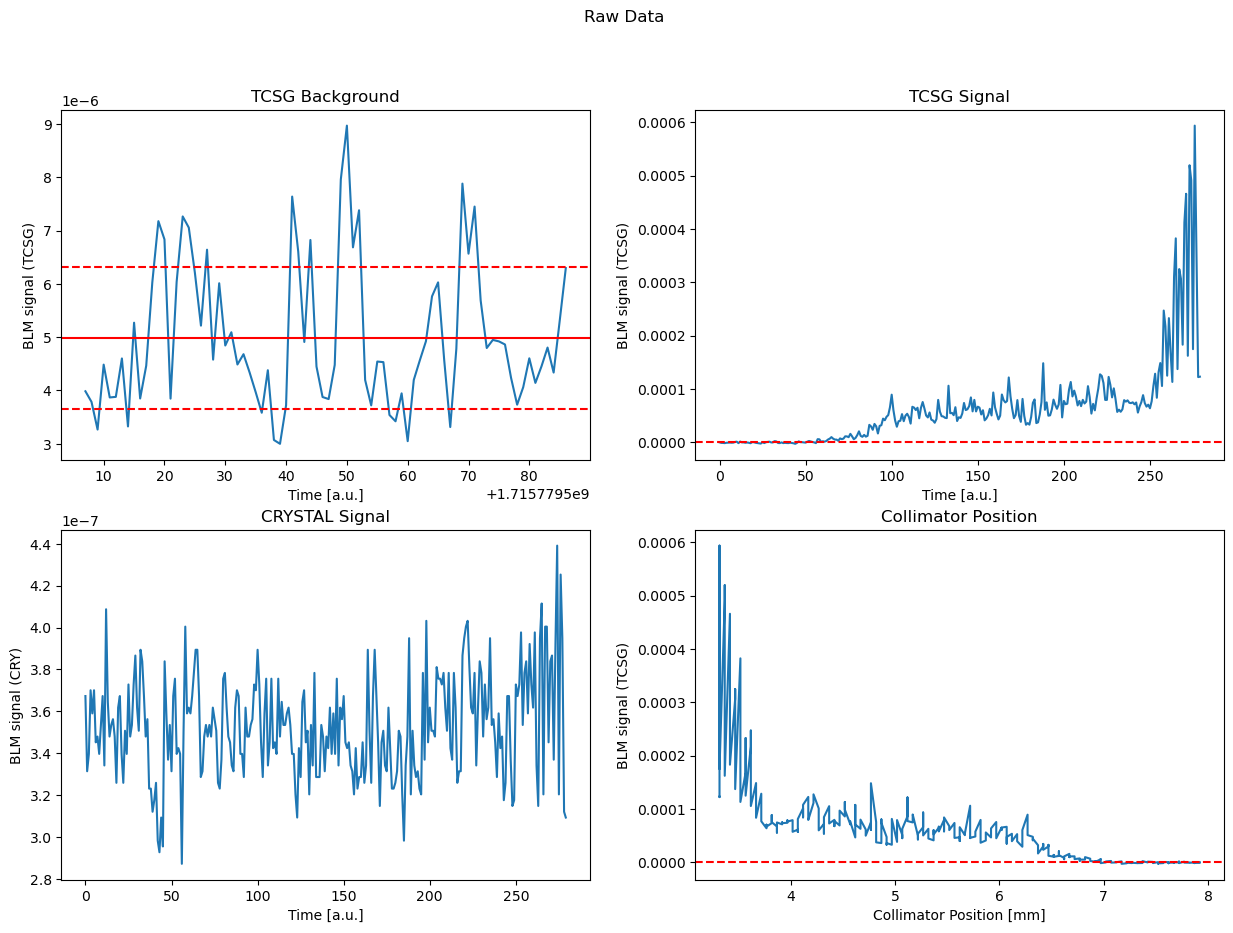

In [16]:
# LOAD AND PREPROCESS DATA


Bkg_data = lbd.get(blm_metadata, tMin_bkg , tMax_bkg )
DeltaBLM_bkg = Bkg_data[blm_metadata][0]
BLM_bkg =  Bkg_data[blm_metadata][1]

fig, ax = plt.subplots(2, 2,  figsize=(15,10))
fig.suptitle('Raw Data')

#BLM_bkg = [i - MeanBLMCryBkg_NoBeam for i in BLM_bkg]




# BACKGROUND
# compute mean background
bkg_mean = np.mean(BLM_bkg)
bkg_std = np.std(BLM_bkg)
ax[0,0].plot(DeltaBLM_bkg, BLM_bkg)
ax[0,0].axhline(y=bkg_mean, color='r', linestyle='-')
ax[0,0].axhline(y=bkg_mean + bkg_std, color='r', linestyle='--')
ax[0,0].axhline(y=bkg_mean - bkg_std, color='r', linestyle='--')
ax[0,0].set_xlabel('Time [a.u.]')
ax[0,0].set_ylabel("BLM signal (TCSG)")
ax[0,0].set_title('TCSG Background')





# SIGNAL on the ABSORBER
Scan_data = lbd.get(blm_metadata, tMin, tMax)
DeltaBLM = Scan_data[blm_metadata][0]
SignalBLM =  Scan_data[blm_metadata][1]

# Rescale time
DeltaBLM = np.array([i - DeltaBLM[0] for i in DeltaBLM])
# Subtract background
SignalBLM = SignalBLM - bkg_mean

ax[0,1].plot(DeltaBLM, SignalBLM)
ax[0,1].axhline(y=0, color='r', linestyle='--')
ax[0,1].set_xlabel('Time [a.u.]')
ax[0,1].set_ylabel("BLM signal (TCSG)")
ax[0,1].set_title('TCSG Signal')


# SIGNAL on the CRYSTAL
SignalCRY = lbd.get(cry_metadata, tMin, tMax )[cry_metadata][1]


ax[1,0].plot(DeltaBLM, SignalCRY)
ax[1,0].set_xlabel('Time [a.u.]')
ax[1,0].set_ylabel("BLM signal (CRY)")
ax[1,0].set_title('CRYSTAL Signal')


# COLLIMATOR POSITION
CollPos = lbd.get(lin_metadata, tMin , tMax)[lin_metadata][1]
ax[1,1].plot(CollPos, SignalBLM)
#ax[1,1].set_ylim(0, 0.00004)
ax[1,1].axhline(y=0, color='r', linestyle='--')
ax[1,1].set_xlabel('Collimator Position [mm]')
ax[1,1].set_ylabel('BLM signal (TCSG)')
ax[1,1].set_title('Collimator Position')


# BEAM INTENSITY
BeamInt = lbd.get(int_metadata, tMin, tMax )[int_metadata][1]

In [17]:
# REDUCE DATA: if the absorber stays in the same position for more than one measurement, compute the mean of the signals

LSdata_full = pd.DataFrame({'CollPos': CollPos,
                    "BLM_Coll": SignalBLM,
                    "BLM_CRY": SignalCRY,
                    "BeamInt": BeamInt,
                    "Time": DeltaBLM}
                    )

LSdata = LSdata_full.groupby('CollPos').mean()
LSdata['BLM_Coll_Err'] =  LSdata_full.groupby('CollPos')['BLM_Coll'].apply(lambda x: ((x.max()+bkg_std) - (x.min()-bkg_std)) / 2)
#LSdata['BLM_Coll_Err'] =  LSdata_full.groupby('CollPos')['BLM_Coll'].std()
LSdata = LSdata.reset_index()


# CALCULATE DEFLECTION ANGLE

mp = 0.9382    #GeV
emittance_n = 3.5e-6

gamma = energy/mp
beta = np.sqrt(1-1/gamma**2)
emittance = emittance_n/(beta*gamma)

LSdata['Theta'] = -((LSdata['CollPos']*1e-3 - n_sigma*np.sqrt(emittance*beta_COLL)*np.cos(deltaphi_CRY_COLL))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL)))*1e6

In [18]:
LSdata

,CollPos,BLM_Coll,BLM_CRY,BeamInt,Time,BLM_Coll_Err,Theta
0,3.32,2.741217e-04,3.524109e-07,2.009581e+11,277.0,0.000237,13.328559
1,3.37,3.907833e-04,3.894196e-07,2.014822e+11,273.0,0.000180,12.453605
2,3.42,3.536835e-04,3.719279e-07,2.018126e+11,270.0,0.000143,11.578652
3,3.47,2.562845e-04,3.737691e-07,2.021471e+11,267.0,0.000095,10.703698
4,3.52,2.686612e-04,3.737691e-07,2.024158e+11,264.0,0.000136,9.828744
...,...,...,...,...,...,...,...
88,7.72,1.283220e-07,3.691661e-07,2.087385e+11,12.0,0.000003,-63.667382
89,7.77,6.631985e-07,3.535156e-07,2.088199e+11,9.0,0.000002,-64.542336
90,7.82,-3.964277e-07,3.544362e-07,2.089017e+11,6.0,0.000001,-65.417290
91,7.87,-9.377485e-07,3.562775e-07,2.089525e+11,3.0,0.000002,-66.292243


Check signal close to the beam:
Pos:  3.32 	Signal:  0.0002741217119216919
Pos:  3.37 	Signal:  0.0003907833411534627
Pos:  3.42 	Signal:  0.00035368353341420493
Pos:  3.47 	Signal:  0.00025628445504506425
Pos:  3.52 	Signal:  0.0002686611843744913
Pos:  3.57 	Signal:  0.00017541039091746008
Pos:  3.62 	Signal:  0.00019003986174265545
Pos:  3.67 	Signal:  0.0001213611660639445
Pos:  3.72 	Signal:  0.00010381979440053303
Pos:  3.77 	Signal:  6.727511666615803e-05
Pos:  3.82 	Signal:  7.924861723581949e-05
Pos:  3.87 	Signal:  6.605806547800699e-05
Pos:  3.92 	Signal:  7.340180021921793e-05
Pos:  3.97 	Signal:  7.653280709584554e-05
Pos:  4.02 	Signal:  6.623022022247315e-05


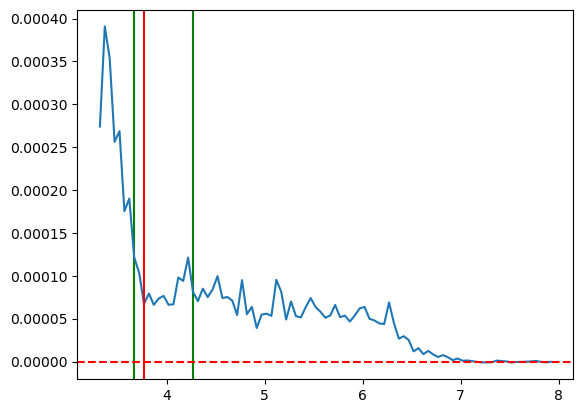

In [14]:
# CHOOSE WHEN TOUCHING THE BEAM
print("Check signal close to the beam:")
for i in range(15):
    print('Pos: ', LSdata.iloc[i].CollPos, '\tSignal: ', LSdata.iloc[i].BLM_Coll)

set_lims = True
if set_lims == True:
    PosEnvelope = 3.77
    RangetoMeanEnv= [0.1, 0.50]

plt.axvline(PosEnvelope-RangetoMeanEnv[0], color = 'g')
plt.axvline(PosEnvelope+RangetoMeanEnv[1], color = 'g')
plt.plot(LSdata.CollPos, LSdata.BLM_Coll)
plt.axvline(PosEnvelope, color = 'red')
plt.axhline(y=0, color='r', linestyle='--')

/tmp/cmaccani/ipykernel_32304/3635812635.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


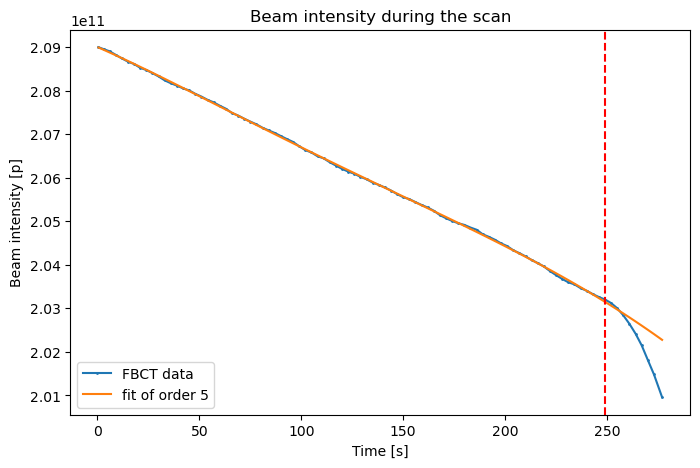

In [15]:
# ------------- BEAM INTENSITY PLOT -------------------
       
# time at which we reach the spike
TimeEnv = LSdata[LSdata['CollPos'] == PosEnvelope].Time.values[0]

# interval time to fit
Time_fit = LSdata[LSdata['Time'] <= TimeEnv].Time
BeamInt_fit = LSdata[LSdata['Time'] <= TimeEnv].BeamInt

fig, ax = plt.subplots(figsize=(8,5))
ax.set_title('Beam intensity during the scan')
ax.plot(LSdata.Time, LSdata.BeamInt, label='FBCT data', marker='o', markersize=1)

# Least squares polynomial fit. Polynomial coefficients, highest power first. 
order = 5
p = np.polyfit(Time_fit, BeamInt_fit, order)

#Return the derivative of the specified order of a polynomial.
# q is a n-1 order polynomial
q = np.polyder(p)

#Evaluate a polynomial at specific values.
BeamIntCurve = np.polyval(p, LSdata.Time)

ax.plot(LSdata.Time, BeamIntCurve, label=f'fit of order {order}')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Beam intensity [p]')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.axvline(TimeEnv, color='r', linestyle='--')
ax.legend()

fig.show()
#f0.tight_layout(rect=[0, 0.03, 1, 0.95])




Text(0, 0.5, 'Beam flux [p/s]')

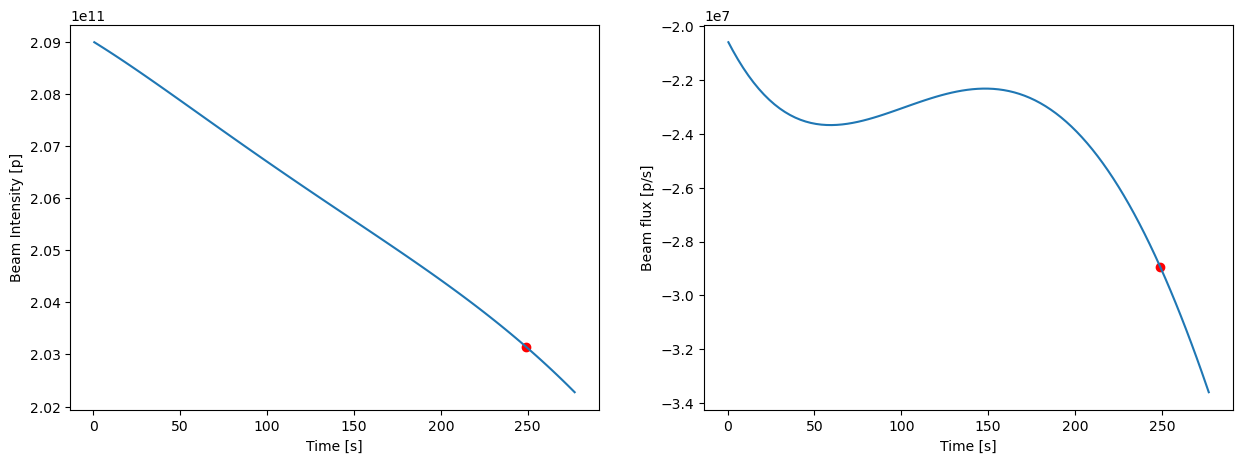

In [16]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(TimeEnv, np.polyval(p, TimeEnv), 'ro')
ax[0].plot(LSdata.Time, np.polyval(p,LSdata.Time))
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Beam Intensity [p]')



ax[1].plot(TimeEnv,np.polyval(q, TimeEnv), 'ro')
ax[1].plot(LSdata.Time, np.polyval(q,LSdata.Time))
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Beam flux [p/s]')


3.1346317259565432e-12 7.502884096624501e-13


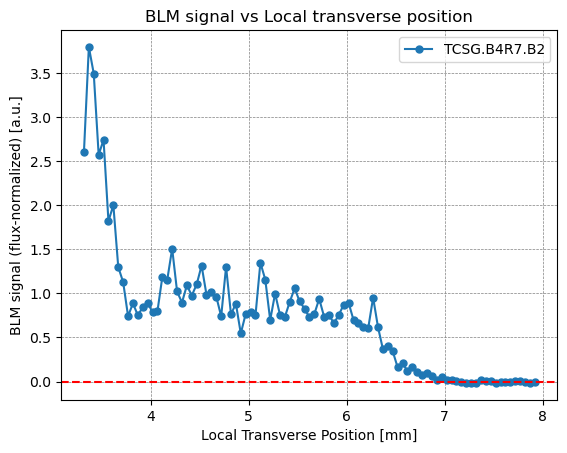

In [17]:
# in the range in which we want to normalize to 1, normalize to derivative beam intensity and compute the mean 
df_tomean = LSdata[(LSdata['CollPos'] >= PosEnvelope-RangetoMeanEnv[0]) & (LSdata['CollPos'] <= PosEnvelope+RangetoMeanEnv[1])]

use_weighted_mean = False
if use_weighted_mean == True:
    BLM_Coll_to_mean = df_tomean.BLM_Coll/np.polyval(q, df_tomean.Time)
    BLM_Coll_Err_to_mean = df_tomean.BLM_Coll_Err/np.polyval(q, df_tomean.Time)
    weights = 1/np.square(BLM_Coll_Err_to_mean)
    normal =  np.sum(BLM_Coll_to_mean* weights) / np.sum(weights)
    normal_err = np.sqrt(1/np.sum(weights))
else:
    normal = abs((df_tomean.BLM_Coll/np.polyval(q, df_tomean.Time)).mean())
    normal_err = abs((df_tomean.BLM_Coll/np.polyval(q, df_tomean.Time)).std())
print(normal, normal_err)

LSdata['BLM_Coll_norm'] = LSdata['BLM_Coll']/abs(np.polyval(q, LSdata['Time'])*normal)
tmp_err =  LSdata['BLM_Coll_Err']/abs(np.polyval(q, LSdata['Time']))

if use_weighted_mean == True:
    LSdata['BLM_Coll_Err_norm'] = np.sqrt((tmp_err/normal)**2 + (LSdata['BLM_Coll']*normal_err/normal**2)**2)
else:
    LSdata['BLM_Coll_Err_norm'] = tmp_err/normal

    
fig, ax = plt.subplots()

plt.title('BLM signal vs Local transverse position')
ax.plot(LSdata.CollPos, LSdata.BLM_Coll_norm, marker='o', markersize=5, label='TCSG.B4R7.B2')
ax.set_xlabel('Local Transverse Position [mm]')
ax.grid(color='gray', linestyle='--', linewidth=0.5)
ax.set_ylabel('BLM signal (flux-normalized) [a.u.]')

plot_crystal = False
if plot_crystal:
    ax2 = ax.twinx()
    ax2.plot(LSdata.CollPos, LSdata.BLM_CRY, marker='o', markersize=5, color='red', label='TCPCH.A5R7.B2')
    ax2.set_ylabel('BLM signal at crystal [Gy/s]')
    ax2.yaxis.grid(False)
    lines4, labels4 = ax2.get_legend_handles_labels()
else:
    lines4, labels4 = [], []

lines3, labels3 = ax.get_legend_handles_labels()

ax.legend(lines3+lines4, labels3+labels4, fontsize=10)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.axhline(y=0, color='r', linestyle='--')

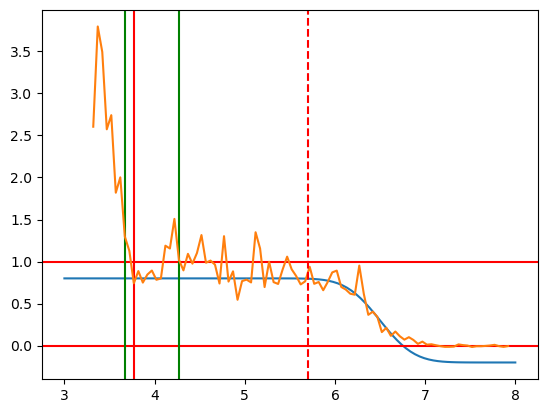

In [18]:
def erfunc(x,a,b,c,d):
	return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))

set_lims = True
if set_lims == True:
	PosMaxErfFit = 5.7
	param0 = [0.3, -1, 6.5, 0.3]

x = np.linspace(3, 8, 100)
plt.plot(x, erfunc(x, param0[0], param0[1], param0[2], param0[3]))
plt.axhline(0, color = 'r')
plt.axhline(1, color = 'r')
plt.axvline(PosEnvelope-RangetoMeanEnv[0], color = 'g')
plt.axvline(PosEnvelope+RangetoMeanEnv[1], color = 'g')
plt.axvline(PosEnvelope, color = 'r')
plt.plot(LSdata.CollPos, LSdata.BLM_Coll_norm)
plt.axvline(PosMaxErfFit, color = 'r', linestyle = '--')

In [19]:
pos_max_list = [5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2]

for pos_max in pos_max_list:
    df_tofit = LSdata[LSdata['CollPos'] > pos_max]
    params, extras = opt.curve_fit(erfunc, df_tofit.CollPos, df_tofit.BLM_Coll_norm, p0=param0, sigma=df_tofit.BLM_Coll_Err_norm)
    deltax = (abs(params[2])-abs(PosEnvelope))*1.0e-3
    theta_calc = (deltax-n_sigma*np.sqrt(emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
    print(pos_max,  round(theta_calc*1.0e6,3), round(abs(params[1])*100,2))

5.4 50.13 83.85
5.5 50.248 82.37
5.6 50.387 80.53
5.7 50.088 84.46
5.8 49.582 90.73
5.9 48.548 103.86
6.0 47.395 120.07
6.1 48.054 109.46
6.2 -19.924 1811250.37


Height:  0.8445982118176604  a.u.
Mean:  6.396392017220201  mm
Sigma:  0.24291239472268372  mm
Calculated theta [urad]:  50.088


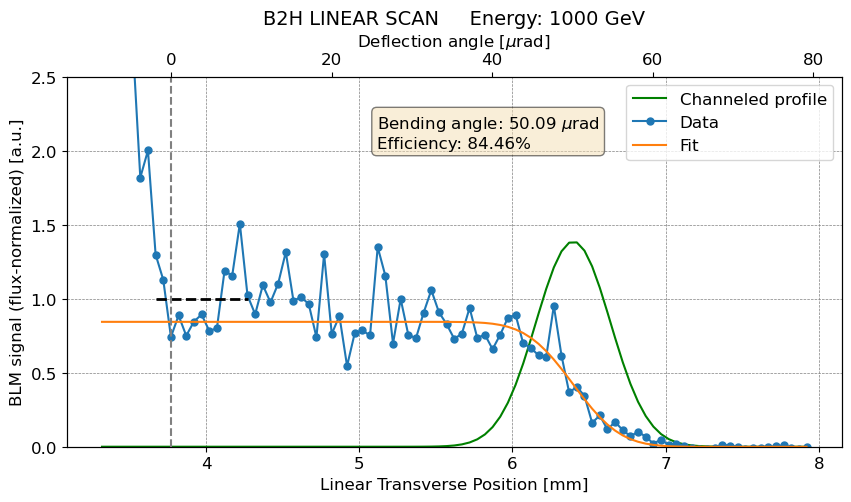

In [26]:
fig, ax = plt.subplots(figsize=(10,5))	

df_tofit = LSdata[LSdata['CollPos'] > PosMaxErfFit]
params, extras = opt.curve_fit(erfunc, df_tofit.CollPos, df_tofit.BLM_Coll_norm, p0=param0, sigma=df_tofit.BLM_Coll_Err_norm)

print('Height: ', abs(params[1]), ' a.u.')
print('Mean: ', params[2], ' mm')
print('Sigma: ', abs(params[3]), ' mm')

# distance between centre of channeled beam and primary beam envelope
deltax = (abs(params[2])-abs(PosEnvelope))*1.0e-3

theta_calc = (deltax-n_sigma*np.sqrt(emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
print('Calculated theta [urad]: ', round(theta_calc*1.0e6,3))


x1 = -abs(PosEnvelope)
y1 = 0
x2 = -abs(params[2])
y2 = theta_calc*1.0e6
m = (y2-y1)/(x2-x1)
q = y1-m*x1

LSdata['CollPos_thetaframe']= -m*LSdata['CollPos']+q


ax.plot(LSdata.CollPos, abs(params[1])*norm.pdf(LSdata.CollPos,params[2],abs(params[3])), label='Channeled profile', color='green')
#ax.errorbar(LSdata.CollPos, LSdata.BLM_Coll_norm, yerr=LSdata.BLM_Coll_Err_norm, label='Data', marker='o', markersize=5)
ax.plot(LSdata.CollPos, LSdata.BLM_Coll_norm, label='Data', marker='o', markersize=5)
ax.plot(LSdata.CollPos, erfunc(LSdata.CollPos, *params), label='Fit', zorder=10)

#ax.plot(LSdata.CollPos, m * LSdata.CollPos + q, color='green', label='Channeled beam profile')

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('Linear Transverse Position [mm]', fontsize=12)
ax.set_ylabel('BLM signal (flux-normalized) [a.u.]', fontsize=12)

ax.hlines(y=1, xmin=PosEnvelope-RangetoMeanEnv[0], xmax=PosEnvelope+RangetoMeanEnv[1], linewidth=2, color='k', linestyles='--')

ax2 = ax.twiny()
ax2.plot(LSdata.CollPos_thetaframe, LSdata.BLM_Coll_norm, alpha=0.0, color='k')
ticks = ax2.get_xticks()
ax2.xaxis.set_major_locator(FixedLocator(ticks))
ax2.set_xticklabels([int(abs(tick)) for tick in ticks])
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlabel('Deflection angle [$\mu$rad]', fontsize=12)


# ax.get_yaxis().set_visible(False)
ax.set_ylim(0,2.5)
ax.grid(color='gray', linestyle='--', linewidth=0.5)
# ax.yaxis.grid(False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
lines1, labels1 = ax.get_legend_handles_labels()
plt.legend(lines1, labels1, fontsize=12)
ax.grid(color='gray', linestyle='--', linewidth=0.5)
textstr = 'Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc*1.0e6,3),round(abs(params[1])*100,2),)+'%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.4, 0.8, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)
ax2.axvline(0, color='grey', linestyle='--')

#ax.axvline(PosMaxErfFit, color='r', linestyle='--')

ax.set_title(f'B2H LINEAR SCAN     Energy: {energy} GeV', fontsize=14)

save_fig = True
if save_fig:
    plt.subplots_adjust(top=0.85)  
    fig.savefig(f'./Plots/B2H_LINEAR_SCAN_energy{energy}_scan{scan}.png')


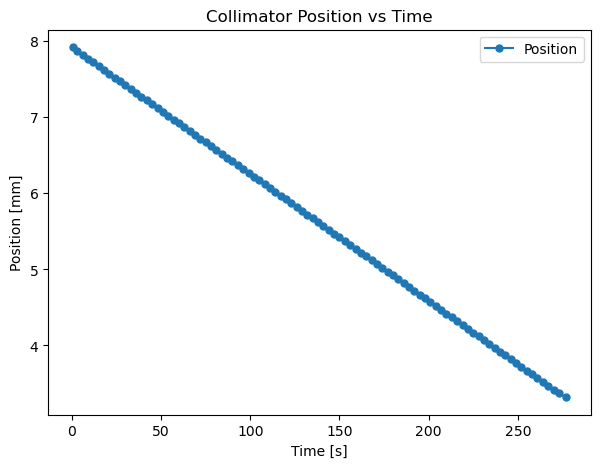

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_title('Collimator Position vs Time')
ax.plot(LSdata.Time, LSdata.CollPos, label='Position', marker='o', markersize=5)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Position [mm]')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.legend()

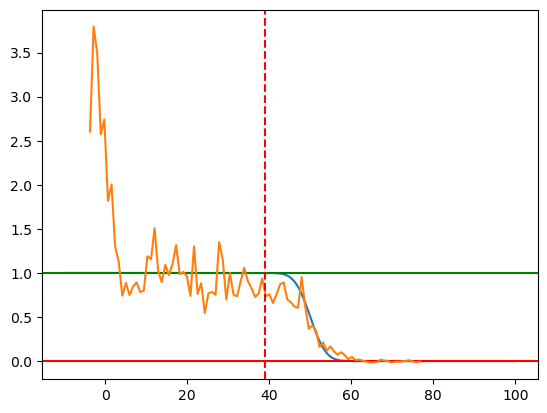

In [21]:

LSdata['Angle'] = (((LSdata.CollPos*1.0e-3-PosEnvelope*1e-3)-n_sigma*np.sqrt(emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_COLL*beta_CRY)*np.sin(deltaphi_CRY_COLL)))*1.0e6


param0_2 = [0.5, -1, 50, 3]
AngleMaxErfFit = 39

x = np.linspace(-10, 100, 500)
plt.plot(x, erfunc(x, param0_2[0], param0_2[1], param0_2[2], param0_2[3]))
#plt.axvline(0, color = 'r')
plt.axhline(0, color = 'r')
plt.axhline(1, color = 'g')
plt.plot(LSdata.Angle, LSdata.BLM_Coll_norm)
plt.axvline(AngleMaxErfFit, color = 'r', linestyle = '--')

Height:  0.8434167436709675  a.u.
Mean:  50.09686828195996  urad
Sigma:  4.242128624291886  urad


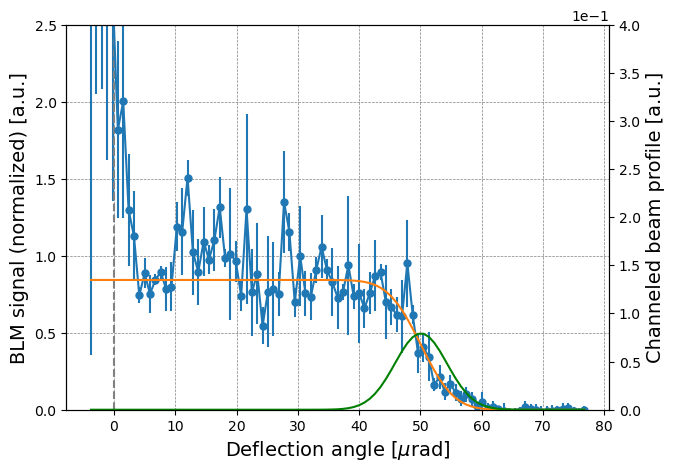

In [22]:
df_tofit_ang = LSdata[LSdata['Angle'] > AngleMaxErfFit]

params_2, extras_2 = opt.curve_fit(erfunc, df_tofit_ang.Angle, df_tofit_ang.BLM_Coll_norm, p0=param0_2, sigma=df_tofit_ang.BLM_Coll_Err_norm)
print('Height: ', abs(params_2[1]), ' a.u.')
print('Mean: ', params_2[2], ' urad')
print('Sigma: ', abs(params_2[3]), ' urad')

fig, ax = plt.subplots(figsize=(7,5))
ax2 = ax.twinx()
# ax2.get_yaxis().set_visible(False)
ax.errorbar(LSdata.Angle, LSdata.BLM_Coll_norm, yerr=LSdata.BLM_Coll_Err_norm, label='Data', marker='o', markersize=5)
ax2.plot(LSdata.Angle, abs(params_2[1])*norm.pdf(LSdata.Angle,params_2[2],abs(params_2[3])), label='Ch beam profile', color='green')
ax.plot(LSdata.Angle, erfunc(LSdata.Angle, *params_2), label='Fit', zorder=10)
ax.set_xlabel('Deflection angle [$\mu$rad]', fontsize=14)
ax.set_ylabel('BLM signal (normalized) [a.u.]', fontsize=14)
ax2.set_ylabel('Channeled beam profile [a.u.]', fontsize=14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.axvline(0, color='grey', linestyle='--')
ax.set_ylim(0,2.5)
ax2.set_ylim(0,0.4)
ax.grid(color='gray', linestyle='--', linewidth=0.5)
